Speech Emotion Recognition Neural Networks







DOWNLOADING ALL DATASETS

In [ ]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

!unzip speech-emotion-recognition-en.zip

Streaming output truncated to the last 5000 lines.
  inflating: Crema/1088_IWW_FEA_XX.wav  
  inflating: Crema/1088_IWW_HAP_XX.wav  
  inflating: Crema/1088_IWW_NEU_XX.wav  
  inflating: Crema/1088_IWW_SAD_XX.wav  
  inflating: Crema/1088_MTI_ANG_XX.wav  
  inflating: Crema/1088_MTI_DIS_XX.wav  
  inflating: Crema/1088_MTI_FEA_XX.wav  
  inflating: Crema/1088_MTI_HAP_XX.wav  
  inflating: Crema/1088_MTI_NEU_XX.wav  
  inflating: Crema/1088_MTI_SAD_XX.wav  
  inflating: Crema/1088_TAI_ANG_XX.wav  
  inflating: Crema/1088_TAI_DIS_XX.wav  
  inflating: Crema/1088_TAI_FEA_XX.wav  
  inflating: Crema/1088_TAI_HAP_XX.wav  
  inflating: Crema/1088_TAI_NEU_XX.wav  
  inflating: Crema/1088_TAI_SAD_XX.wav  
  inflating: Crema/1088_TIE_ANG_XX.wav  
  inflating: Crema/1088_TIE_DIS_XX.wav  
  inflating: Crema/1088_TIE_FEA_XX.wav  
  inflating: Crema/1088_TIE_HAP_XX.wav  
  inflating: Crema/1088_TIE_NEU_XX.wav  
  inflating: Crema/1088_TIE_SAD_XX.wav  
  inflating: Crema/1088_TSI_ANG_XX.wav  
  infl

Importing Required Libraries

In [ ]:
# Importing System Libraries
import os, sys

# Importing Data Manipulation Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Machine Learning Libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Importing Audio Processing Libraries
import librosa
import librosa.display
import soundfile
from IPython.display import Audio, display

# Importing Deep Learning Libraries
import tensorflow
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

# Ignore Warnings
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

Loading the Dataset

In [ ]:
# Dataset Paths
crema = "/content/Crema/" # Contains voices of male and female
savee = "/content/Savee/" # Contain only male voice data
tess = "/content/Tess/" # Have both
ravdess = "/content/Ravdess/audio_speech_actors_01-24/"

Loading SAVEE Data
The audio files in SAVEE are named in such a way that the prefix letters describes the emotion classes as follows:

'a' = 'anger'
'd' = 'disgust'
'f' = 'fear'
'h' = 'happiness'
'n' = 'neutral'
'sa' = 'sadness'
'su' = 'surprise'

In [ ]:
# Loading the SAVEE data

savee_directory_list = os.listdir(savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    if file[-8:-6] == '_a':
        file_emotion.append('angry')

    elif file[-8:-6] == '_d':
        file_emotion.append('disgust')

    elif file[-8:-6] == '_f':
        file_emotion.append('fear')

    elif file[-8:-6] == '_h':
        file_emotion.append('happy')

    elif file[-8:-6] == '_n':
        file_emotion.append('neutral')

    elif file[-8:-6] == 'sa':
        file_emotion.append('sad')

    elif file[-8:-6] == 'su':
        file_emotion.append('surprise')

    else:
        file_emotion.append('unknown')

    file_path.append(savee + file)

savee_df = pd.DataFrame(file_emotion, columns = ['Emotions'])
savee_df['Path'] = file_path
savee_df.head()

,Emotions,Path
0,fear,/content/Savee/KL_f14.wav
1,angry,/content/Savee/JE_a15.wav
2,neutral,/content/Savee/JE_n22.wav
3,neutral,/content/Savee/KL_n13.wav
4,fear,/content/Savee/KL_f06.wav


In [ ]:
savee_df['Emotions'].value_counts()

,count
Emotions,
neutral,120
fear,60
angry,60
surprise,60
disgust,60
sad,60
happy,60


Loading The CREMAD Data

In [ ]:
crema_directory_list = os.listdir(crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # Storing file paths
    file_path.append(crema + file)
    # Storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('unknown')

# Dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# Dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.head()

,Emotions,Path
0,disgust,/content/Crema/1071_IEO_DIS_LO.wav
1,neutral,/content/Crema/1064_IWL_NEU_XX.wav
2,angry,/content/Crema/1049_IOM_ANG_XX.wav
3,sad,/content/Crema/1048_ITS_SAD_XX.wav
4,neutral,/content/Crema/1081_ITS_NEU_XX.wav


Loading the RAVDESS Data
Here is the filename identifiers as per the official RAVDESS website:

Modality (01 = full-AV, 02 = video-only, 03 = audio-only). Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

[ ]


In [ ]:
# Loading the RAVDESS data
ravdess_directory_list = os.listdir(ravdess)
file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    # There are 24 different actors in RAVDESS directory, so we have to extract the files for each actor

    actor = os.listdir(ravdess + dir)

    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')

        file_emotion.append(int(part[2]))
        # Storing file paths
        file_path.append(ravdess + dir + '/' + file)

ravdess_df = pd.DataFrame(file_emotion, columns = ['Emotions'])
ravdess_df['Path'] = file_path
ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace = True)
ravdess_df.head()

,Emotions,Path
0,neutral,/content/Ravdess/audio_speech_actors_01-24/Act...
1,sad,/content/Ravdess/audio_speech_actors_01-24/Act...
2,fear,/content/Ravdess/audio_speech_actors_01-24/Act...
3,neutral,/content/Ravdess/audio_speech_actors_01-24/Act...
4,sad,/content/Ravdess/audio_speech_actors_01-24/Act...


In [ ]:
ravdess_df.Emotions.value_counts()

,count
Emotions,
neutral,288
sad,192
fear,192
disgust,192
happy,192
angry,192
surprise,192


Loading the TESS dataset
It structure is clear, you can see it

In [ ]:
tess_dir_list = os.listdir(tess)
file_emotion = []
file_path = []

for dir in tess_dir_list:
    directories = os.listdir(tess + dir)
    for file in directories:
        file_path.append(tess + dir + '/' + file)

        part = file.split('.')[0]
        part = part.split('_')[2]

        if part == 'ps':
            file_emotion.append('surprise')
        elif part == 'happy':
            file_emotion.append('happy')
        elif part == 'sad':
            file_emotion.append('sad')
        elif part == 'fear':
            file_emotion.append('fear')
        elif part == 'angry':
            file_emotion.append('angry')
        elif part == 'disgust':
            file_emotion.append('disgust')
        elif part == 'neutral':
            file_emotion.append('neutral')
        else:
            file_emotion.append('unknown')

tess_df = pd.DataFrame(file_emotion, columns = ['Emotions'])
tess_df['Path'] = file_path
tess_df.head()

,Emotions,Path
0,surprise,/content/Tess/OAF_Pleasant_surprise/OAF_third_...
1,surprise,/content/Tess/OAF_Pleasant_surprise/OAF_boat_p...
2,surprise,/content/Tess/OAF_Pleasant_surprise/OAF_dodge_...
3,surprise,/content/Tess/OAF_Pleasant_surprise/OAF_hash_p...
4,surprise,/content/Tess/OAF_Pleasant_surprise/OAF_rain_p...


In [ ]:
tess_df.Emotions.value_counts()

,count
Emotions,
surprise,400
fear,400
happy,400
sad,400
disgust,400
neutral,400
angry,400


Visualuzatiion

In [ ]:
sns.set_style(style='whitegrid')

<ipython-input-12-9e4e6b6fe9dd>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'Emotions', data = tess_df, palette = 'Set1', legend = False)


Text(0.5, 1.0, 'Count of Emotions in CREMA-D')

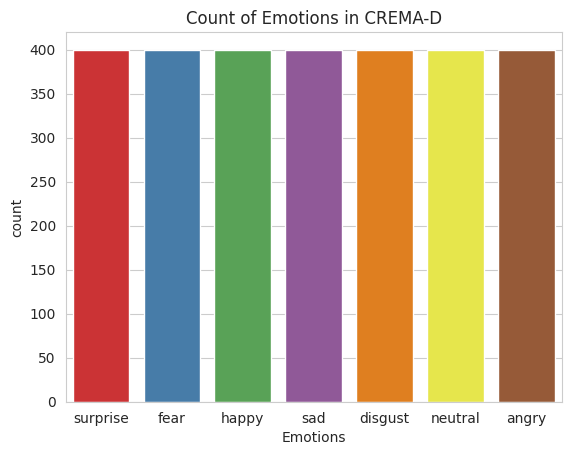

In [ ]:
sns.countplot(x = 'Emotions', data = tess_df, palette = 'Set1', legend = False)
plt.title('Count of Emotions in CREMA-D')

In [ ]:
# df = pd.concat([crema_df, ravdess_df, savee_df, tess_df], axis = 0)
# df.reset_index(drop = True, inplace = True)
# df.head()

In [ ]:
# Function to plot waveform
def plot_waveform(file_path, emotion, duration=2.5, offset=0.6):
    """
    Plot the waveform of an audio file.

    Parameters:
    - file_path (str): Path to the audio file.
    - emotion (str): Emotion label for the audio file.
    - duration (float): Duration to load from the audio file (in seconds).
    - offset (float): Offset from the start of the file to begin loading (in seconds).
    """
    # Load the audio file
    y, sr = librosa.load(file_path, duration=duration, offset=offset)

    # Plot waveform
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr, alpha=0.7)
    plt.title(f'Waveform - Emotion: {emotion}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Function to plot spectrogram
def plot_spectrogram(file_path, emotion, duration=2.5, offset=0.6):
    """
    Plot the spectrogram of an audio file.

    Parameters:
    - file_path (str): Path to the audio file.
    - emotion (str): Emotion label for the audio file.
    - duration (float): Duration to load from the audio file (in seconds).
    - offset (float): Offset from the start of the file to begin loading (in seconds).
    """

    # Load the audio file
    y, sr = librosa.load(file_path, duration=duration, offset=offset)

    # Compute the Short-Time Fourier Transform (STFT)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    # Plot spectrogram
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='coolwarm')
    plt.title(f'Spectrogram - Emotion: {emotion}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

In [ ]:
tess_df.Emotions.value_counts()

,count
Emotions,
surprise,400
fear,400
happy,400
sad,400
disgust,400
neutral,400
angry,400


Visualizing /content/Tess/YAF_angry/YAF_king_angry.wav - Emotion: angry


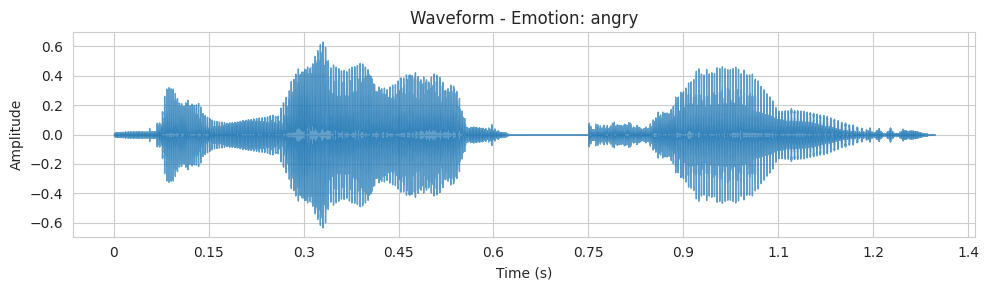

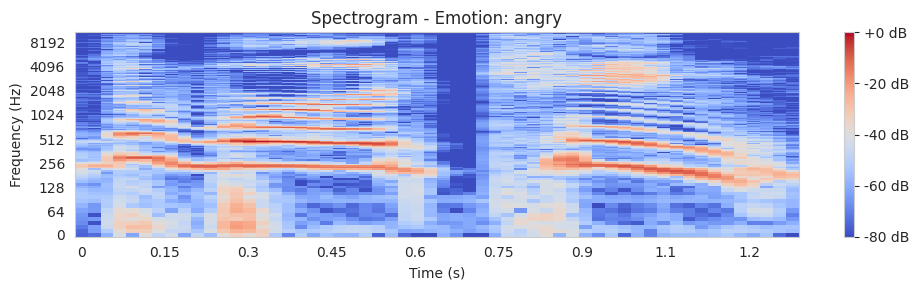

Visualizing /content/Tess/OAF_disgust/OAF_chain_disgust.wav - Emotion: disgust


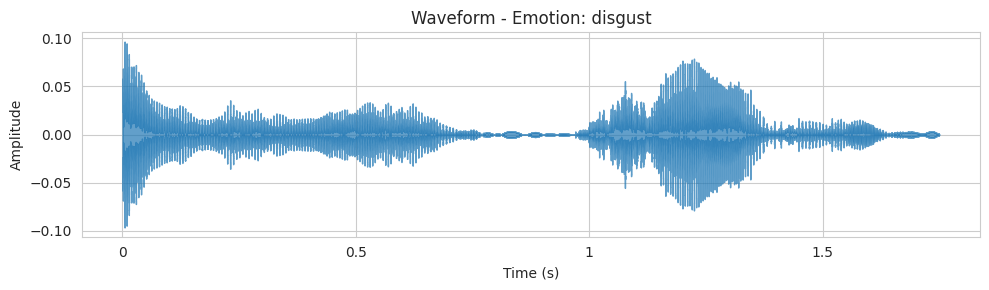

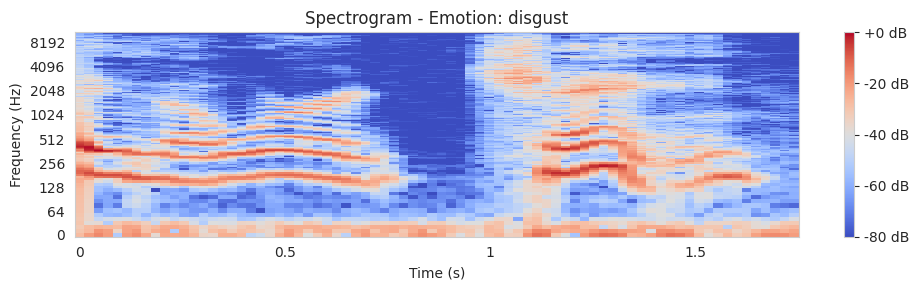

Visualizing /content/Tess/OAF_Fear/OAF_turn_fear.wav - Emotion: fear


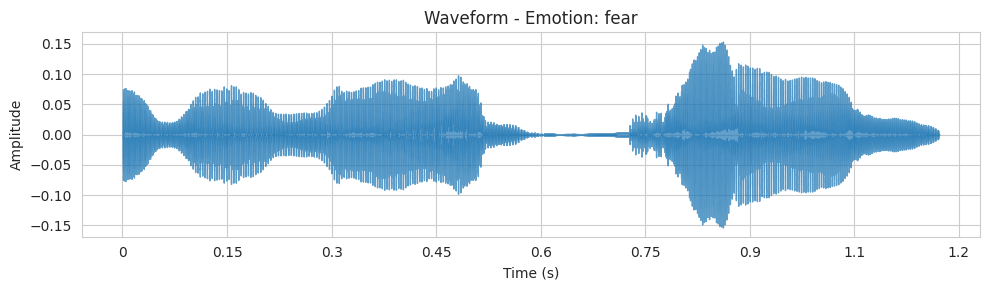

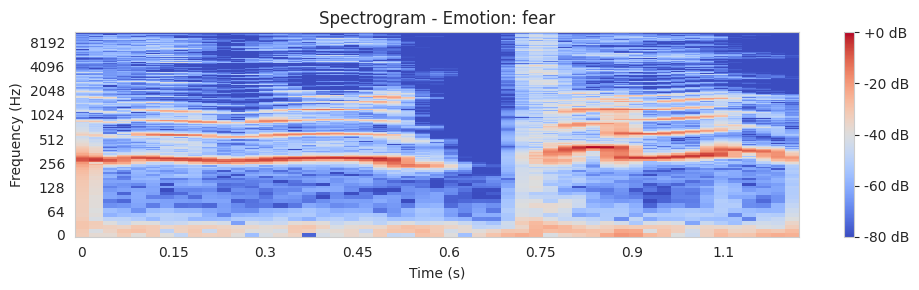

Visualizing /content/Tess/YAF_happy/YAF_chat_happy.wav - Emotion: happy


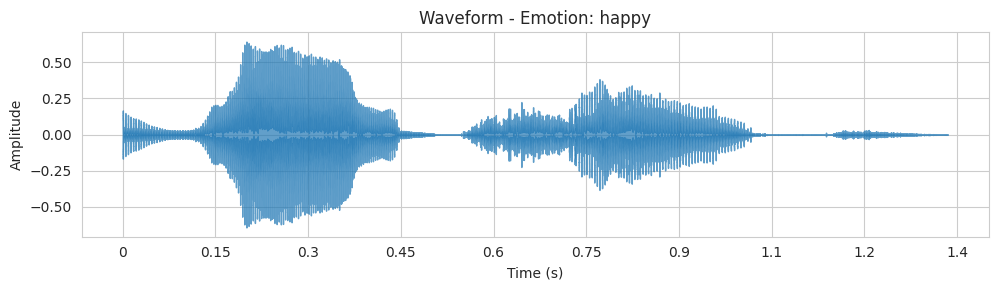

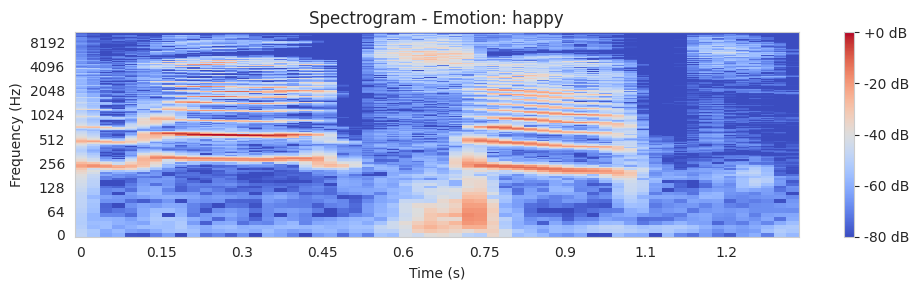

Visualizing /content/Tess/YAF_neutral/YAF_nag_neutral.wav - Emotion: neutral


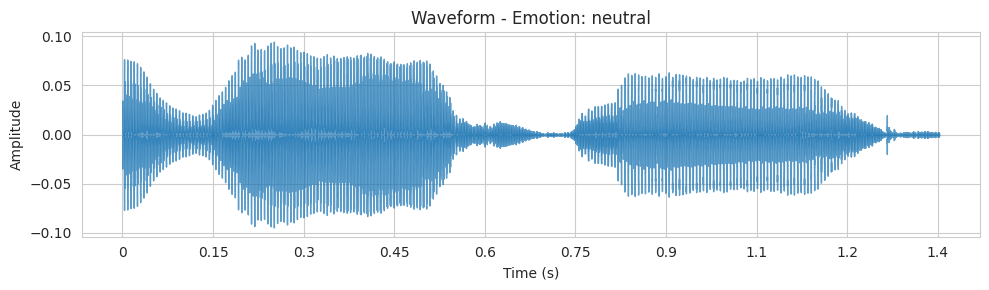

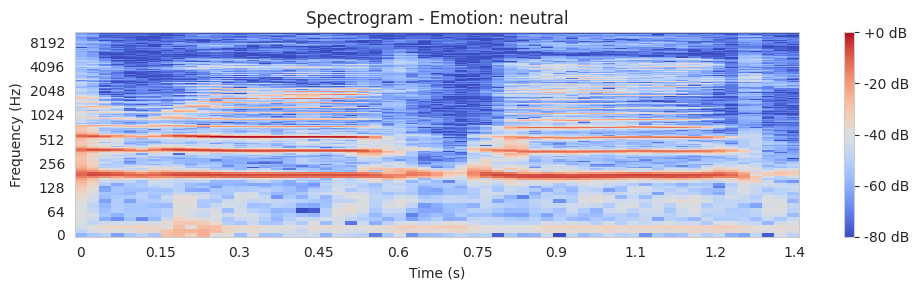

Visualizing /content/Tess/YAF_sad/YAF_mess_sad.wav - Emotion: sad


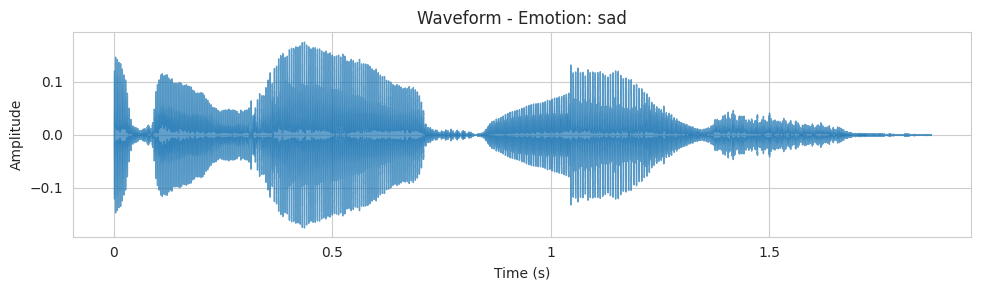

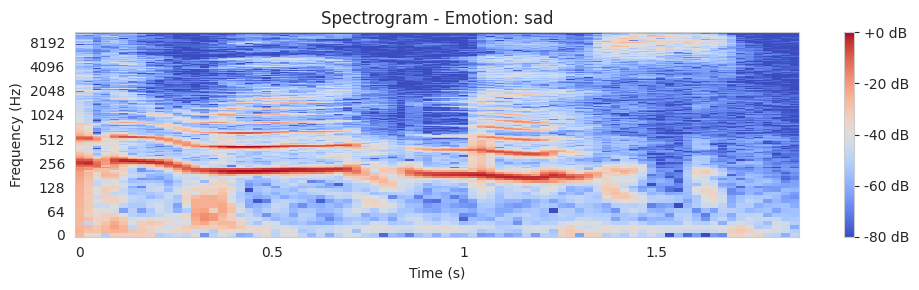

In [ ]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

# Creating a dataframe which will hold distinct emotion from data
each_emotion_df = pd.DataFrame(columns = ['Emotions', 'Path'])

# Appending each emotion in the each_emotion_df
for emotion in emotions:
    row = tess_df[tess_df['Emotions'] == emotion].sample(1)
    each_emotion_df = pd.concat([each_emotion_df, row], axis = 0)

# Plotting Waveplot and Spectogram for each emotion
for index, row in each_emotion_df.iterrows():
    file_path = row['Path']
    emotion = row['Emotions']
    print(f"Visualizing {file_path} - Emotion: {emotion}")
    plot_waveform(file_path, emotion)
    plot_spectrogram(file_path, emotion)
    display(Audio(file_path))

Feature Extraction:

> Add blockquote



In [ ]:
# tess_df

In [ ]:
# def extract_features(file_path):
#     y, sr = librosa.load(file_path)
#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#     return mfccs.mean(axis=1)

# tess_df['features'] = tess_df['Path'].apply(extract_features) # Extracting features from audio files


In [ ]:
# crema_df.features[0].shape

In [ ]:
# Function to extract features from audio files
def extract_features(file_name):
    """
    Extracts audio features from a file.

    Parameters:
    - file_name (str): Path to the audio file.

    Returns:
    - features (np.ndarray): Extracted feature vector.
    """
    y, sr = librosa.load(file_name, duration=2.5, offset=0.6)

    # Extract various features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    # Aggregate features
    features = np.hstack([
        np.mean(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.mean(mel, axis=1),
        np.mean(contrast, axis=1),
        np.mean(zcr, axis=1)
    ])

    return features

def extract_features_df(data):
    """
    Extracts features from a DataFrame of audio files.

    Parameters:
    - df (pd.DataFrame): DataFrame containing audio file paths.

    Returns:
    - features_df (pd.DataFrame): DataFrame with extracted features.
    """

    # Initialize lists to store features and labels
    emotion_labels = []
    features_list = []

    # Iterate through the DataFrame and extract features
    for index, row in data.iterrows():
        file_path = row['Path']
        emotion = row['Emotions']

        # Extract features and append to lists
        features = extract_features(file_path)
        features_list.append(features)
        emotion_labels.append(emotion)

    # Convert lists to a DataFrame
    features_df = pd.DataFrame(features_list)
    features_df['emotion'] = emotion_labels

    return features_df

features_df = extract_features_df(tess_df)
print("Feature extraction complete.")
print("Features shape:", features_df.shape)

Feature extraction complete.
Features shape: (2800, 189)


In [ ]:
features_df

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,emotion
0,-446.315155,112.829247,14.342425,-39.023659,8.230682,11.026679,-15.748294,-17.337051,-15.852318,-0.257778,...,1.582425e-06,25.665823,22.302663,22.618163,19.493095,24.678301,18.132665,48.737785,0.087731,surprise
1,-502.225616,118.673294,21.296684,1.477953,-11.318998,-3.470678,-11.932746,-0.725592,-22.206335,1.056831,...,1.068221e-07,25.932836,24.104829,23.995087,22.215520,20.914745,19.768178,48.676719,0.038326,surprise
2,-428.544586,99.617508,9.661211,-12.444884,2.003477,1.464603,-3.493065,0.907284,-17.750629,1.035864,...,1.356958e-06,25.680595,23.396921,23.017349,19.899460,20.712800,18.958993,48.981716,0.058671,surprise
3,-484.361603,120.937523,-24.553204,-6.934698,3.794154,10.235447,-18.734543,0.451617,-14.263826,0.532874,...,2.592365e-08,27.083578,19.372065,20.688496,18.445759,21.388093,18.673999,47.475571,0.073638,surprise
4,-419.291199,113.946457,3.951624,-22.976511,11.644104,-4.825972,-7.095994,-4.354746,-19.553816,-14.056405,...,2.072864e-06,26.970453,28.111125,27.806754,22.972694,23.259640,20.231342,47.525767,0.044922,surprise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,-341.572113,35.844765,3.971583,7.160751,-29.311501,9.344135,4.916990,-17.644678,0.356384,-0.194206,...,2.590046e-05,15.346397,19.282551,21.254638,18.725168,19.421612,21.876850,48.044968,0.186101,angry
2796,-396.016510,90.454529,7.354483,49.889786,0.305031,2.604546,17.937675,-28.328501,-4.699675,0.909603,...,9.135617e-07,17.765659,21.592271,25.113924,19.511851,22.288620,24.376217,46.436413,0.053090,angry
2797,-323.725281,47.299740,-2.539979,1.883858,-38.233315,2.119192,-3.006588,-26.299232,-7.366420,-2.336159,...,2.478311e-04,17.771870,23.185630,23.725944,21.544185,22.332855,22.892259,49.846434,0.142586,angry
2798,-333.458679,58.150894,-1.925773,-5.385754,-22.938137,7.317567,1.692932,-24.518347,-5.930089,3.373079,...,6.403893e-04,16.323165,21.532705,21.970623,19.949581,19.893277,23.232611,48.705083,0.189422,angry


In [ ]:
# features_df.describe()

In [ ]:
# Encoding the target column
lb = LabelEncoder()
features_df['emotion'] = lb.fit_transform(features_df['emotion'])

# Display the mapping of labels to integers
label_mapping = dict(zip(lb.classes_, lb.transform(lb.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# Splitting the dataset
X = features_df.drop('emotion', axis=1)
y = features_df['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [ ]:
X_train.shape, X_test.shape

((2240, 188), (560, 188))

In [ ]:
# Scaling the inputs
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [ ]:
# X_train

In [ ]:
# One-Hot Encoding the target column
y_train_encoded = to_categorical(y_train, num_classes = y_train.nunique())
y_test_encoded = to_categorical(y_test, num_classes = y_train.nunique())

MODEL BUILDING


Building Model Using CNN & LSTM

In [ ]:
# Reshape the input data for CNN
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the CNN-LSTM model
model = Sequential()

# Input layer
model.add(Input(shape=(X_train_reshaped.shape[1], 1)))

# CNN layers
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(128))
model.add(Dropout(0.3))

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 186, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 93, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 93, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 91, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 45, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 43, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 21, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 21, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 471,431 (1.80 MB)

 Trainable params: 470,535 (1.79 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Early Stopping

# earlystopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [ ]:
# Train the model
history = model.fit(X_train_reshaped, y_train_encoded, epochs=30, batch_size=8, validation_data = (X_test_reshaped, y_test_encoded))

Epoch 1/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.3816 - loss: 1.5361 - val_accuracy: 0.3679 - val_loss: 1.8412
Epoch 2/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - accuracy: 0.7548 - loss: 0.6925 - val_accuracy: 0.9018 - val_loss: 0.2669
Epoch 3/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.8916 - loss: 0.3328 - val_accuracy: 0.8536 - val_loss: 0.3925
Epoch 4/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9192 - loss: 0.2706 - val_accuracy: 0.9589 - val_loss: 0.1212
Epoch 5/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.9534 - loss: 0.1706 - val_accuracy: 0.9589 - val_loss: 0.1037
Epoch 6/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9424 - loss: 0.1729 - val_accuracy: 0.9357 - val_loss: 0.2057
Epoch 7/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9719 - loss: 0.1014 - val_accuracy: 0.9768 - val_loss: 0.0915
Epoch 8/30
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.9761 - loss: 0.0788 - 

(0.0, 3.0)

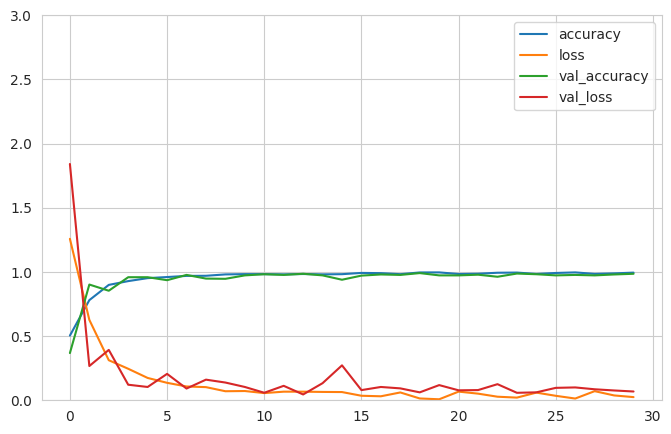

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)

In [ ]:
y_prob = model.predict(X_test_reshaped)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(y_test_encoded, axis = 1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


In [ ]:
# Accuracy
accuracy_score(y_true, y_pred)

0.9857142857142858

In [ ]:
# Confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)
confusion_mat

array([[67,  0,  0,  2,  0,  0,  0],
       [ 0, 77,  0,  0,  0,  1,  2],
       [ 0,  0, 81,  1,  0,  0,  0],
       [ 0,  0,  0, 65,  0,  0,  1],
       [ 0,  0,  0,  0, 89,  0,  0],
       [ 0,  0,  0,  0,  0, 87,  0],
       [ 0,  0,  0,  1,  0,  0, 86]])

In [ ]:
label_mapping

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
# Print the classification report
target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names = target_names))

Classification Report:
              precision    recall  f1-score   support

       angry       1.00      0.97      0.99        69
     disgust       1.00      0.96      0.98        80
        fear       1.00      0.99      0.99        82
       happy       0.94      0.98      0.96        66
     neutral       1.00      1.00      1.00        89
         sad       0.99      1.00      0.99        87
    surprise       0.97      0.99      0.98        87

    accuracy                           0.99       560
   macro avg       0.99      0.98      0.98       560
weighted avg       0.99      0.99      0.99       560



Text(70.72222222222221, 0.5, 'True')

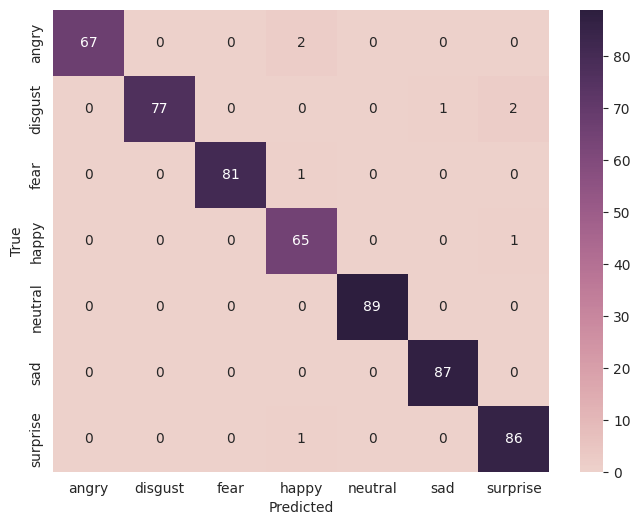

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
# Saving the model
model.save('model.keras')